In [ ]:
!pip install obspy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [ ]:
cat_file_path = '/content/drive/MyDrive/LunarGradeAdata/apollo12_catalog_GradeA_final.csv' #change this to wherever your catalog file is

cat = pd.read_csv(cat_file_path)
cat

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),evid,mq_type
0,xa.s12.00.mhz.1970-01-19HR00_evid00002,1970-01-19T20:25:00.000000,73500.0,evid00002,impact_mq
1,xa.s12.00.mhz.1970-03-25HR00_evid00003,1970-03-25T03:32:00.000000,12720.0,evid00003,impact_mq
2,xa.s12.00.mhz.1970-03-26HR00_evid00004,1970-03-26T20:17:00.000000,73020.0,evid00004,impact_mq
3,xa.s12.00.mhz.1970-04-25HR00_evid00006,1970-04-25T01:14:00.000000,4440.0,evid00006,impact_mq
4,xa.s12.00.mhz.1970-04-26HR00_evid00007,1970-04-26T14:29:00.000000,52140.0,evid00007,deep_mq
...,...,...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00_evid00156,1974-10-14T17:43:00.000000,63780.0,evid00156,impact_mq
72,xa.s12.00.mhz.1975-04-12HR00_evid00191,1975-04-12T18:15:00.000000,65700.0,evid00191,impact_mq
73,xa.s12.00.mhz.1975-05-04HR00_evid00192,1975-05-04T10:05:00.000000,36300.0,evid00192,impact_mq
74,xa.s12.00.mhz.1975-06-24HR00_evid00196,1975-06-24T16:03:00.000000,57780.0,evid00196,impact_mq


In [ ]:
from obspy import read

def load_mseed(file_path):
    """
    Reads and loads a MiniSEED file.

    Parameters:
    file_path (str): Path to the .mseed file.

    Returns:
    Stream object containing the seismic data.
    """
    st = read(file_path)
    tr = st.traces[0].copy()
    return tr


In [ ]:
def get_arrival(st, time):

  tr_times = tr.times()
  tr_data = tr.data
  starttime = tr.stats.starttime.datetime
  return (time - starttime).total_seconds()

In [ ]:
def plot_trace(trace, arrival_time=None, title="Seismic Data"):
    """
    Plots seismic trace data.

    Parameters:
    trace (Trace object): Trace from the Stream object.
    arrival_time (float): Arrival time to mark in seconds (optional).
    title (str): Title for the plot (default: 'Seismic Data').
    """
    times = trace.times()
    data = trace.data

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(times, data)
    if arrival_time:
        ax.axvline(x=arrival_time, color='red', label='Arrival Time')
    ax.set_xlim([min(times), max(times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()


In [ ]:
def apply_bandpass_filter(st, min_freq, max_freq):
    """
    Applies a bandpass filter to the seismic trace.

    Parameters:
    st (Stream object): Stream containing the seismic data.
    min_freq (float): Minimum frequency for the filter.
    max_freq (float): Maximum frequency for the filter.

    Returns:
    Filtered stream.
    """
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin=min_freq, freqmax=max_freq)
    return st_filt

In [ ]:
from obspy.signal.invsim import cosine_taper #used to smooth data at ends
from obspy.signal.filter import highpass #filter to remove low frequency noise from seismic data
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset#used to see when ratio is triggered


def compute_sta_lta(trace, sta_len, lta_len):
    """
    Computes STA/LTA ratio for seismic activity detection.

    Parameters:
    trace (Trace object): Seismic trace data.
    sta_len (float): Length of the short-term average window in seconds.
    lta_len (float): Length of the long-term average window in seconds.

    Returns:
    numpy.ndarray: STA/LTA characteristic function.
    """
    sampling_rate = trace.stats.sampling_rate
    cft = classic_sta_lta(trace.data, int(sta_len * sampling_rate), int(lta_len * sampling_rate))
    return cft


In [ ]:
def plot_sta_lta_triggers(trace, cft, thr_on=4.0, thr_off=1.5):
    """
    Plots the STA/LTA characteristic function and marks trigger points.

    Parameters:
    trace (Trace object): Seismic trace data.
    cft (numpy.ndarray): Characteristic function from STA/LTA.
    thr_on (float): Threshold for detecting start of seismic activity.
    thr_off (float): Threshold for detecting end of seismic activity.
    """
    times = trace.times()
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))

    fig, ax = plt.subplots(1, 1, figsize=(12, 3))

    # Plot the characteristic function
    ax.plot(times, cft, label="STA/LTA")

    # Mark triggers
    for triggers in on_off:
        ax.axvline(x=times[triggers[0]], color='red', label='Trig. On')
        ax.axvline(x=times[triggers[1]], color='purple', label='Trig. Off')

    ax.set_xlim([min(times), max(times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('STA/LTA Ratio')
    ax.legend()
    plt.show()

In [ ]:
def detect_seismic_events(trace, sta_len, lta_len, thr_on=4.0, thr_off=1.5):
    """
    Detects seismic events using STA/LTA method.

    Parameters:
    trace (Trace object): Seismic trace data.
    sta_len (float): Length of the short-term average window in seconds.
    lta_len (float): Length of the long-term average window in seconds.
    thr_on (float): STA/LTA threshold for triggering event start.
    thr_off (float): STA/LTA threshold for event end.

    Returns:
    numpy.ndarray: Onset and offset of seismic events (indices in the trace).
    """
    cft = compute_sta_lta(trace, sta_len, lta_len)
    on_off = np.array(trigger_onset(cft, thr_on, thr_off))
    return on_off

In [41]:
def extract_sta_lta_features(trace, sta_len, lta_len):

    cft = compute_sta_lta(trace, sta_len, lta_len)


    max_sta_lta = np.max(cft)
    mean_sta_lta = np.mean(cft)
    var_sta_lta = np.var(cft)

    return max_sta_lta, mean_sta_lta, var_sta_lta

In [42]:
def extract_time_domain_features(trace):

    data = trace.data

    mean_amp = np.mean(data)
    max_amp = np.max(data)
    rms_amp = np.sqrt(np.mean(data**2))

    return mean_amp, max_amp, rms_amp

In [43]:
def extract_event_duration(trace, sta_len, lta_len, thr_on=4.0, thr_off=1.5):

    cft = compute_sta_lta(trace, sta_len, lta_len)
    on_off = trigger_onset(cft, thr_on, thr_off)

    if len(on_off) > 0:
        # Calculate the durations of each detected event
        event_durations = [(end - start) / trace.stats.sampling_rate for start, end in on_off]
        return np.mean(event_durations) if event_durations else 0
    return 0

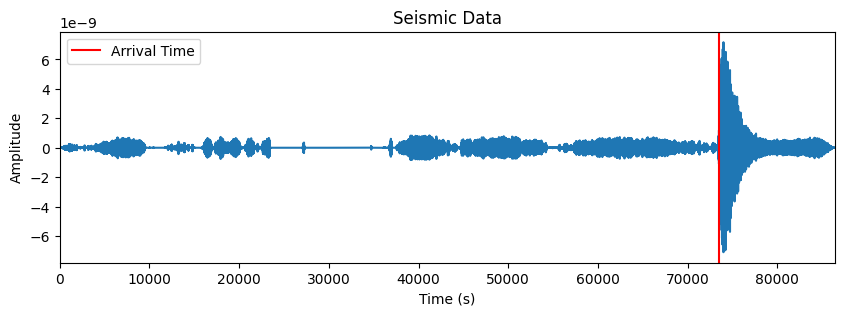

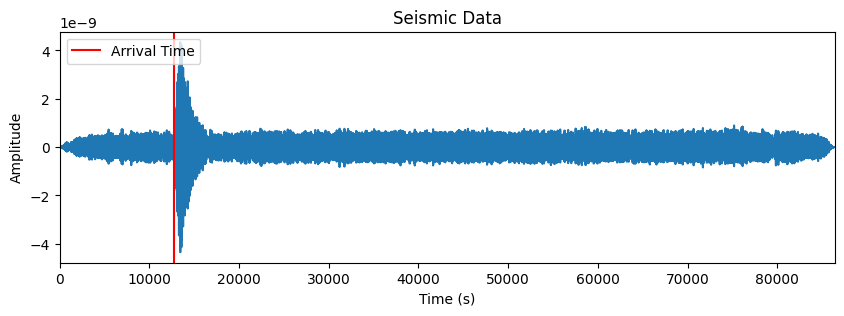

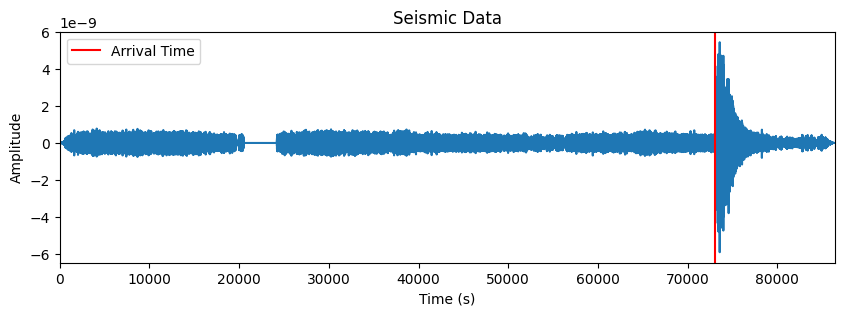

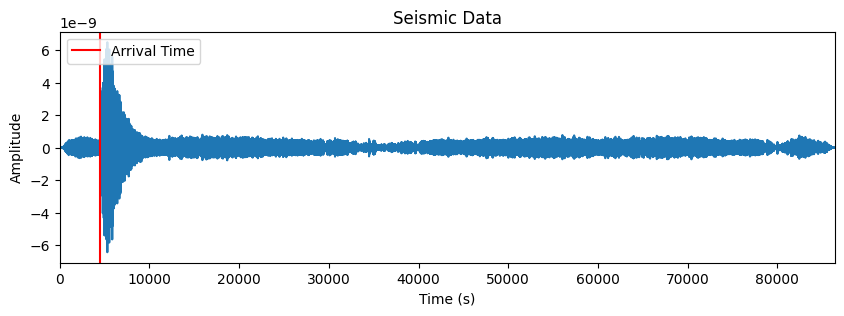

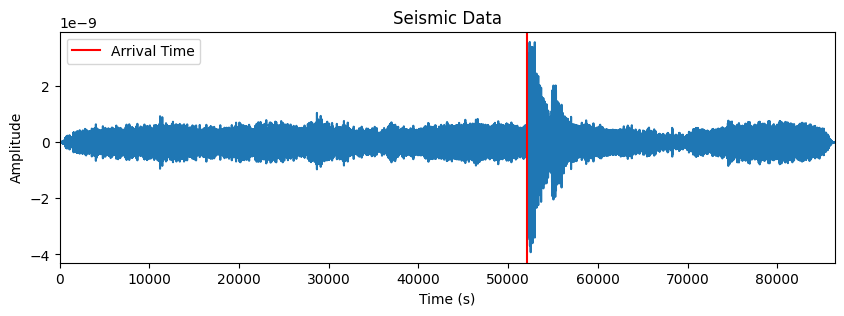

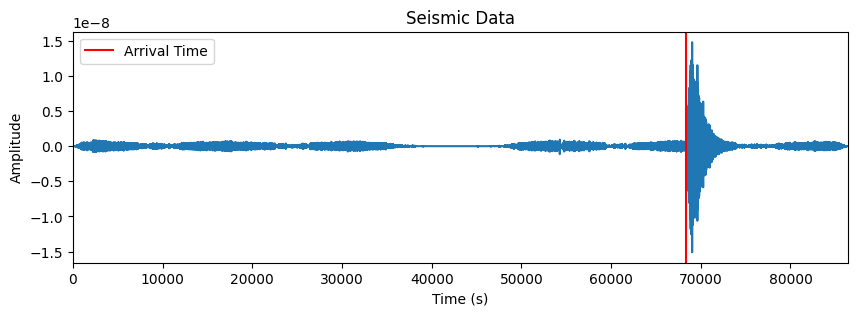

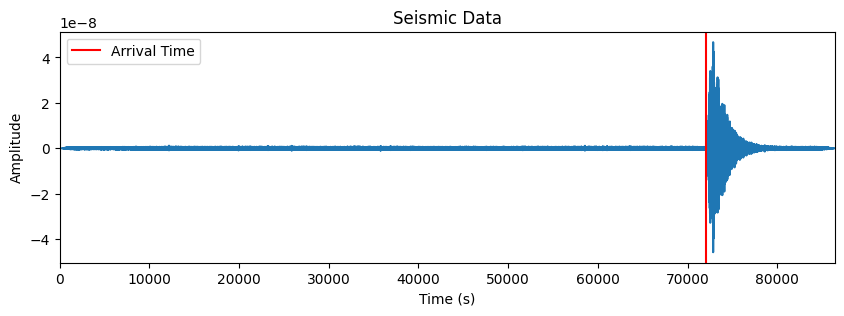

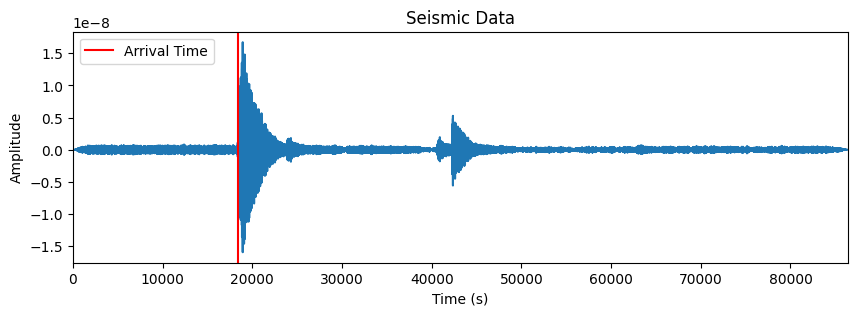

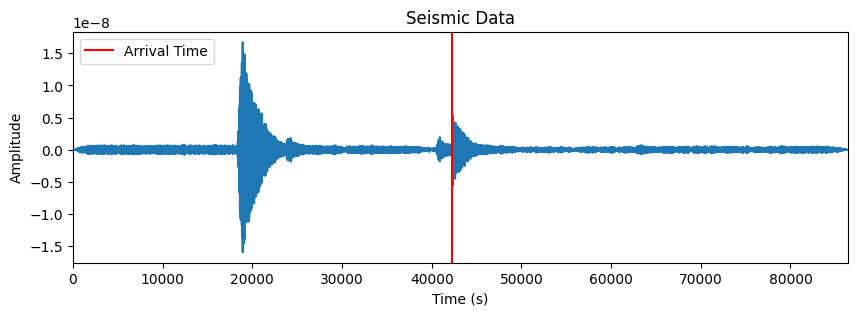

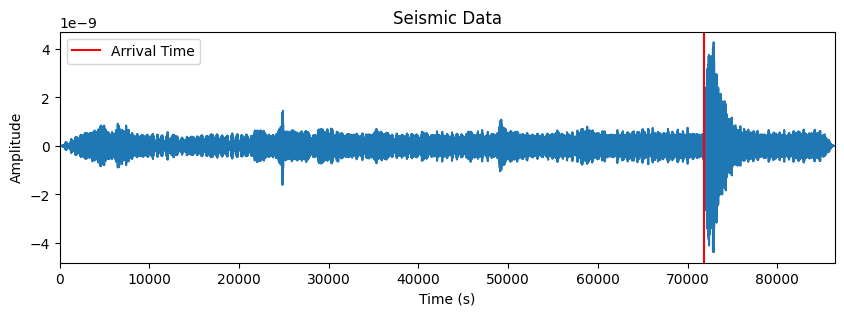

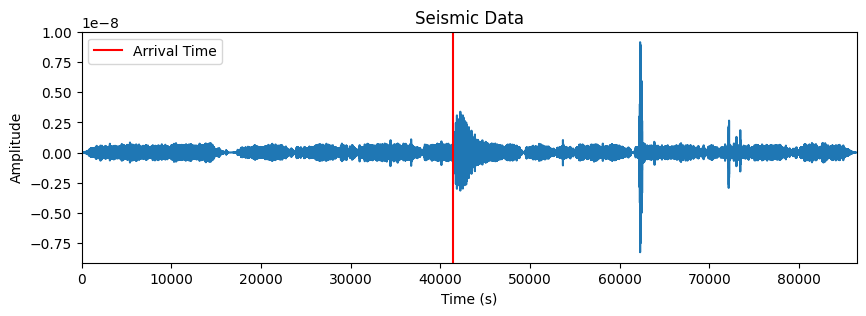

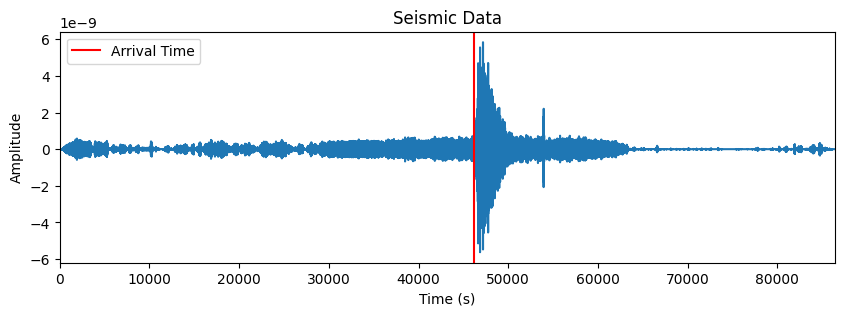

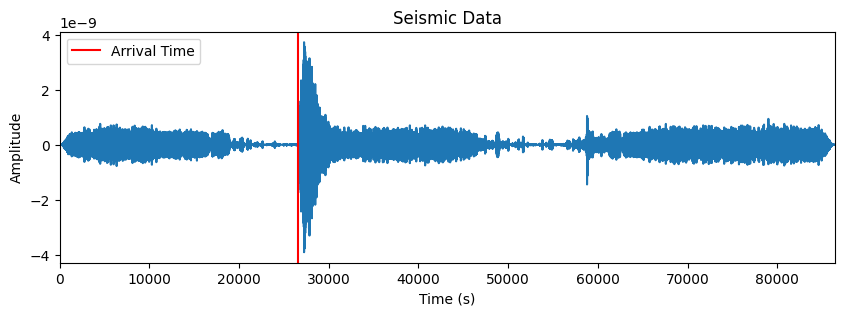

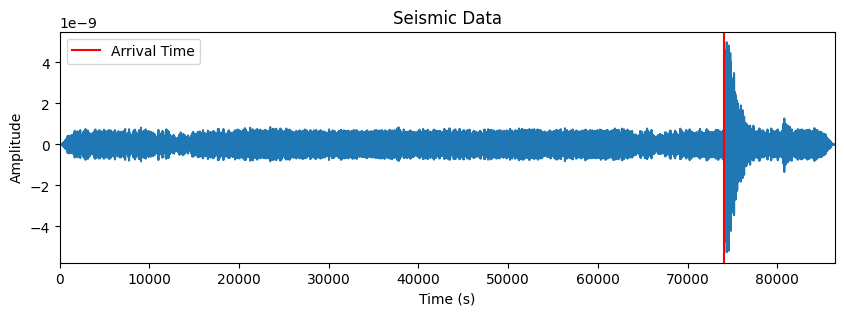

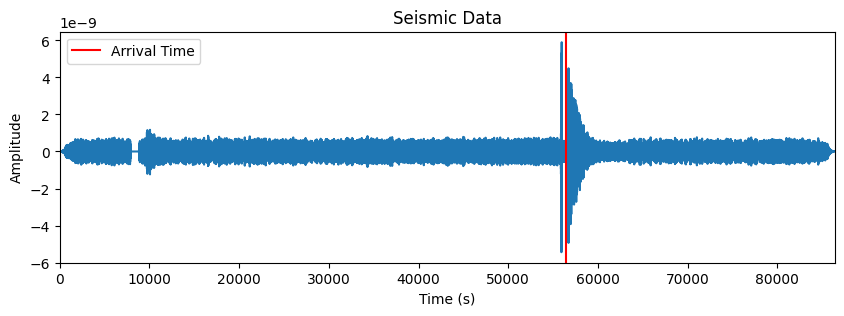

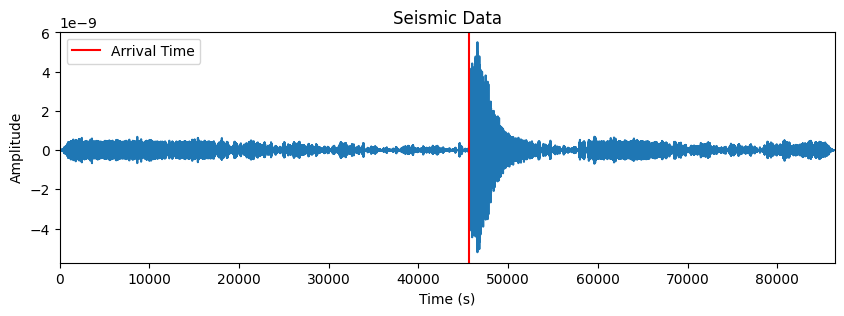

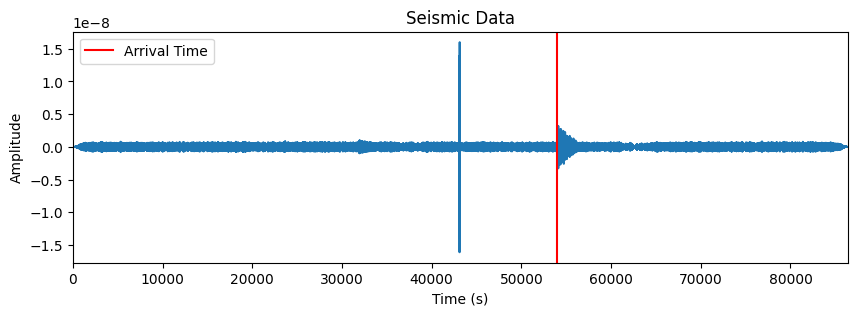

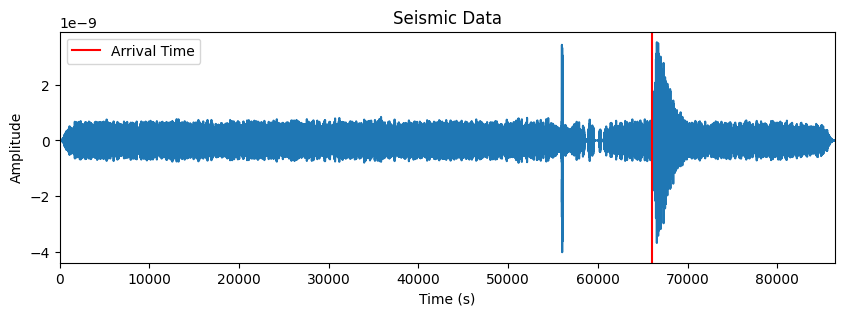

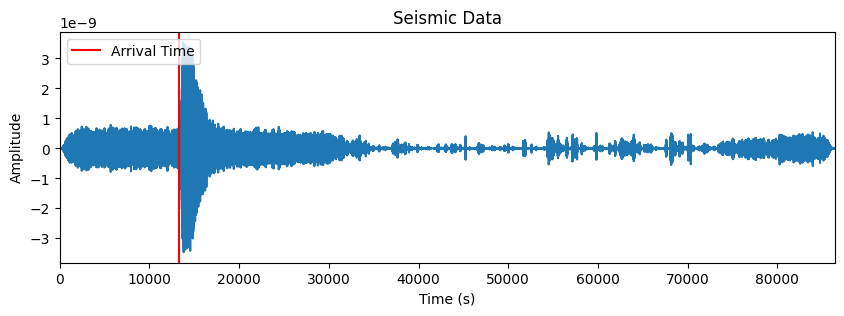

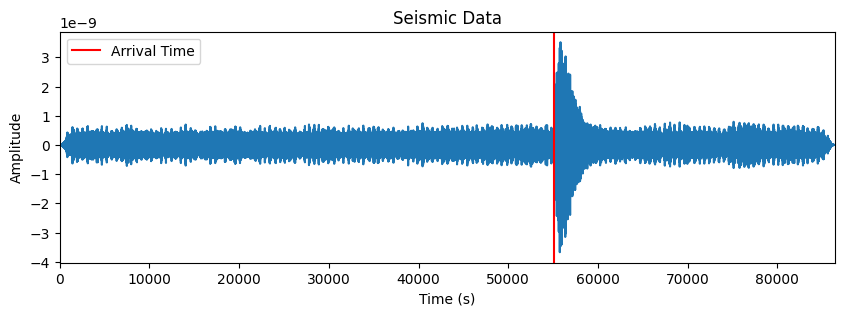

File not found: /content/drive/MyDrive/LunarGradeAData/xa.s12.00.mhz.1971-04-13HR00_evid00029.mseed. Skipping to the next file.


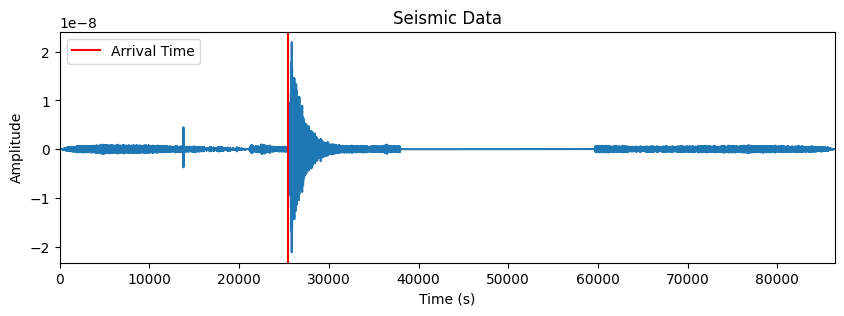

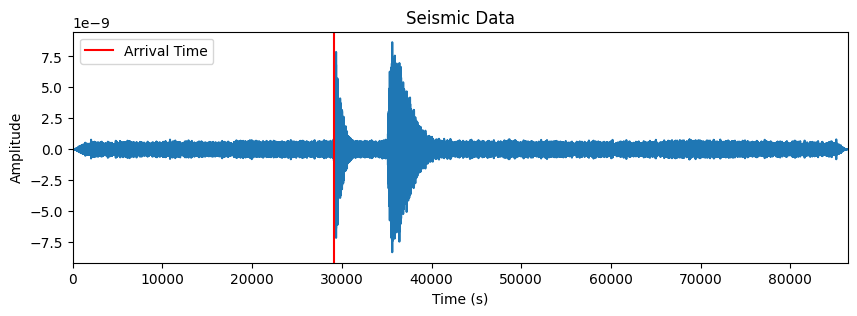

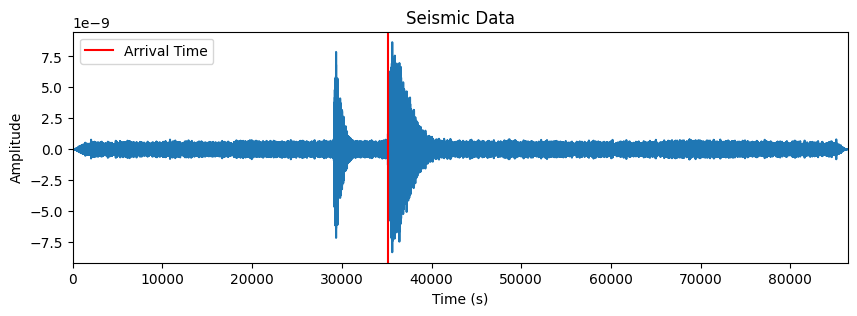

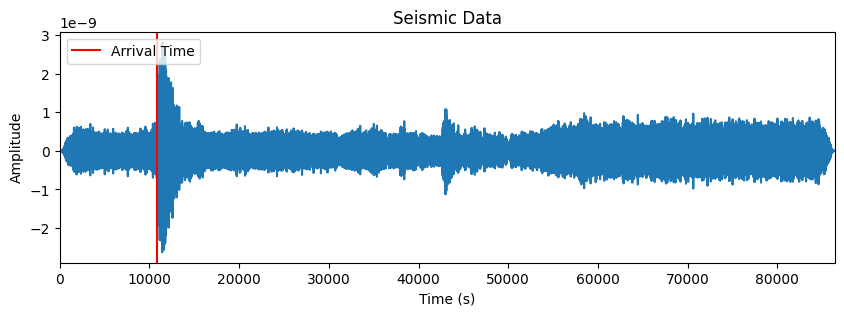

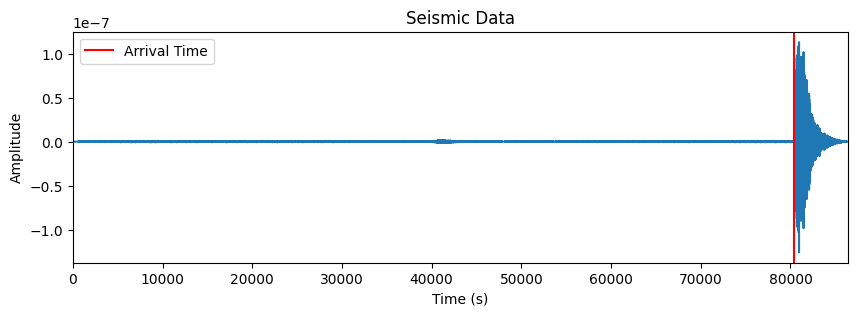

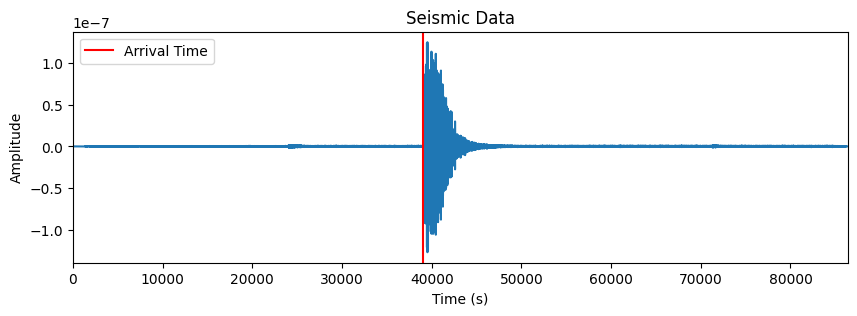

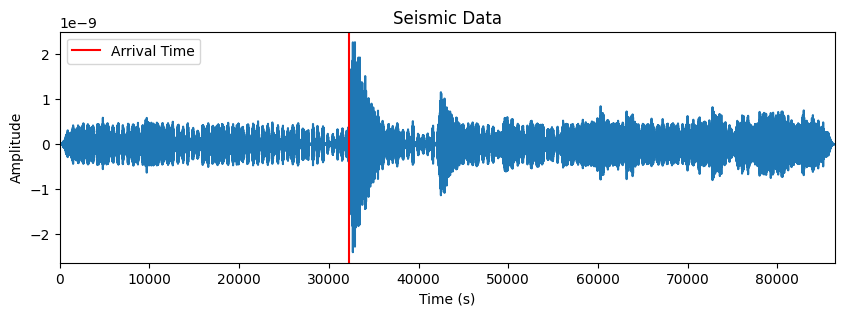

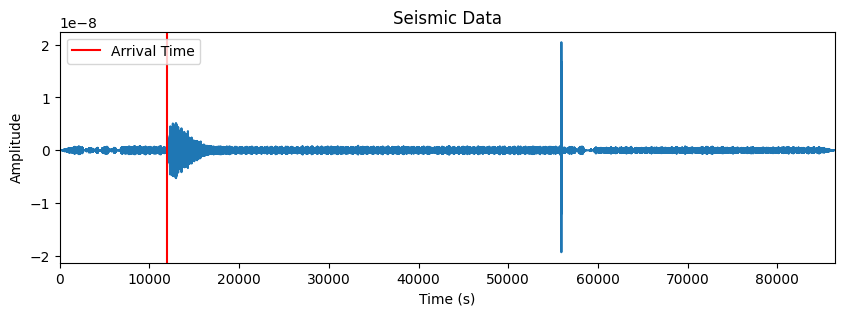

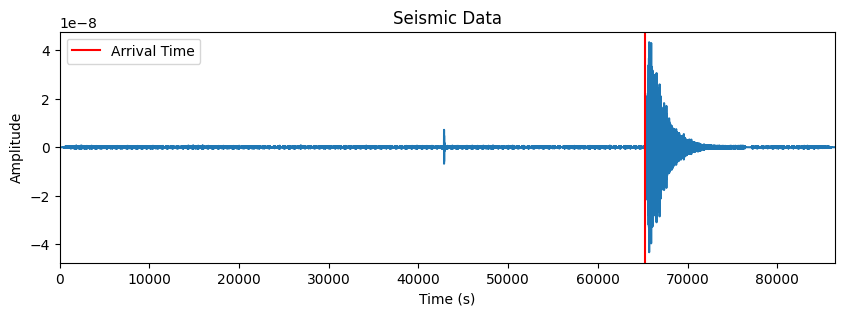

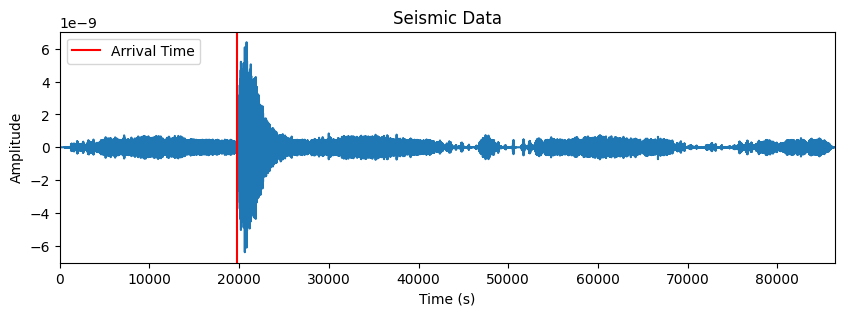

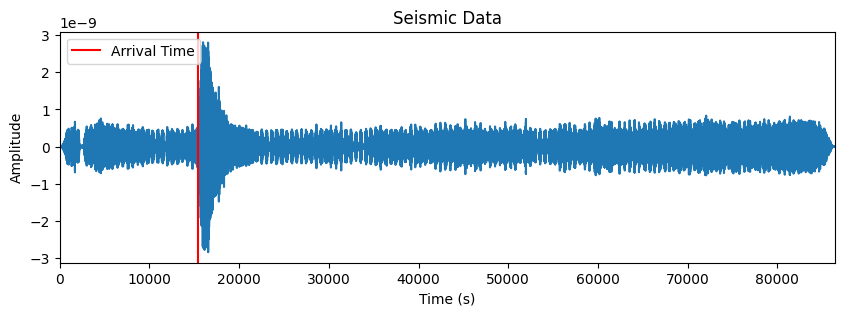

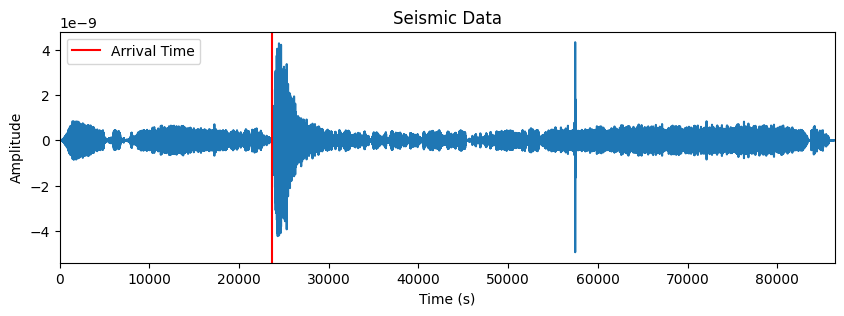

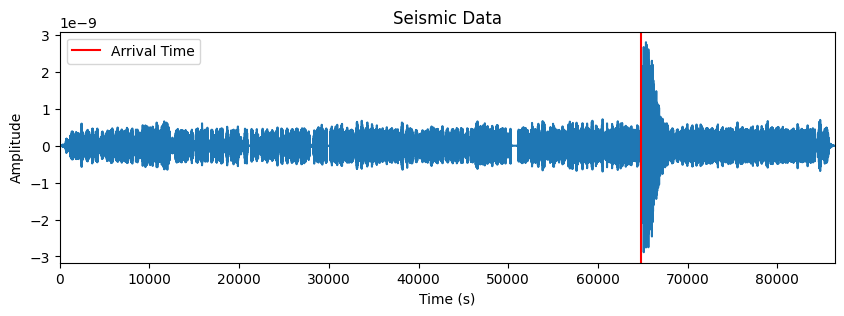

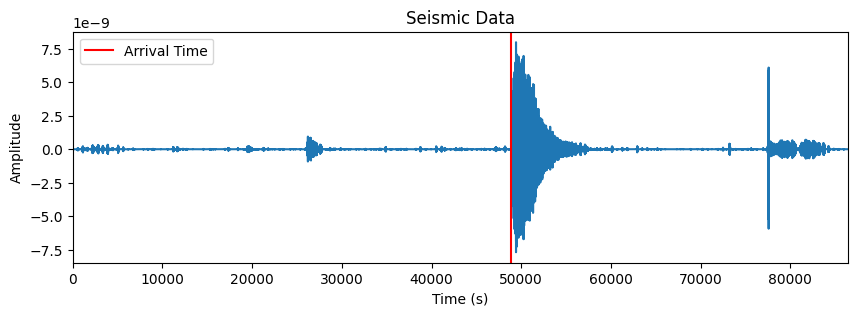

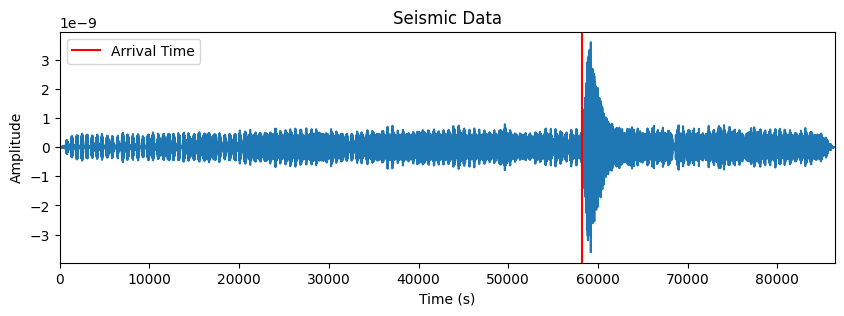

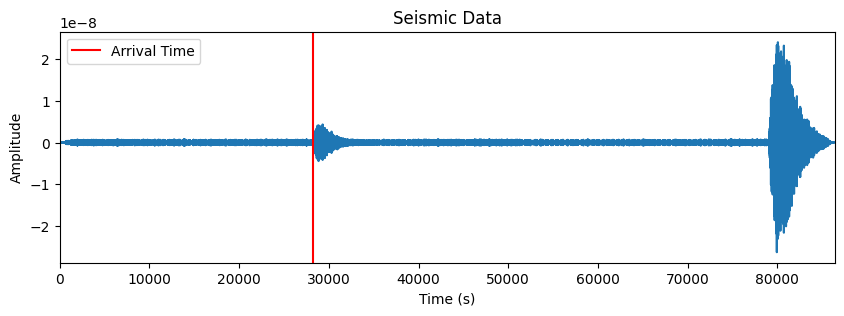

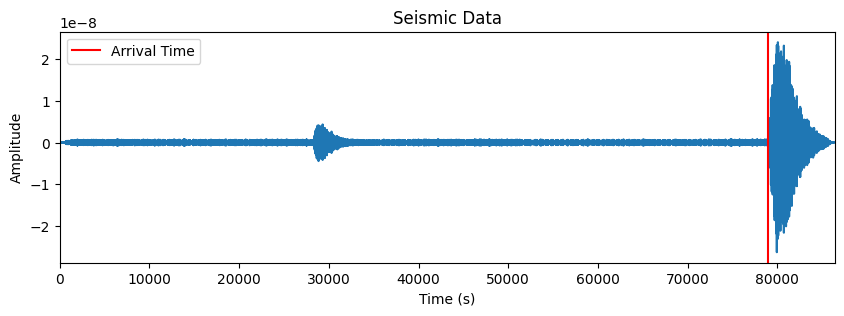

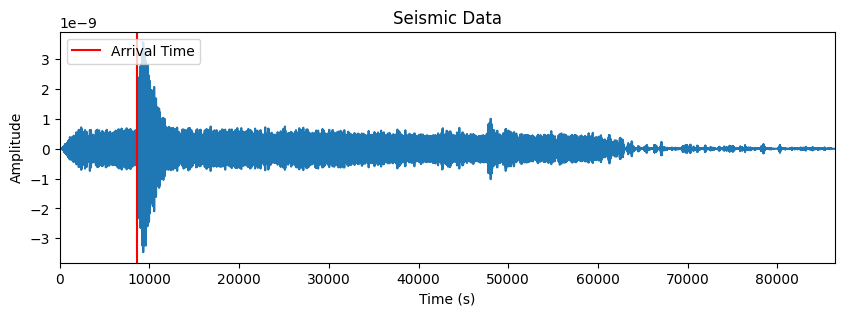

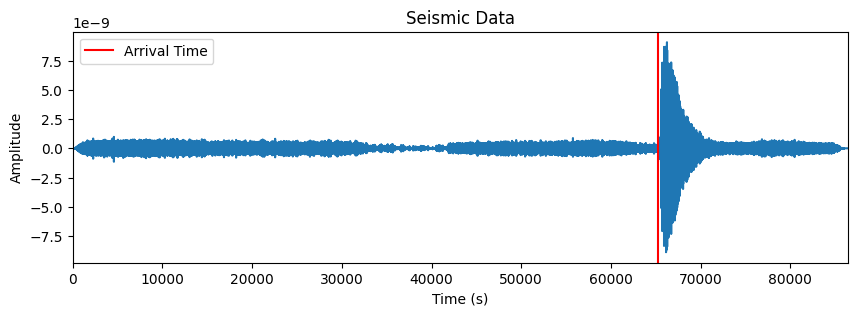

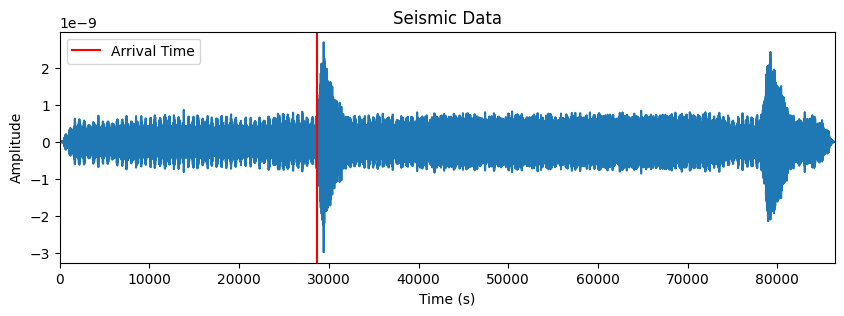

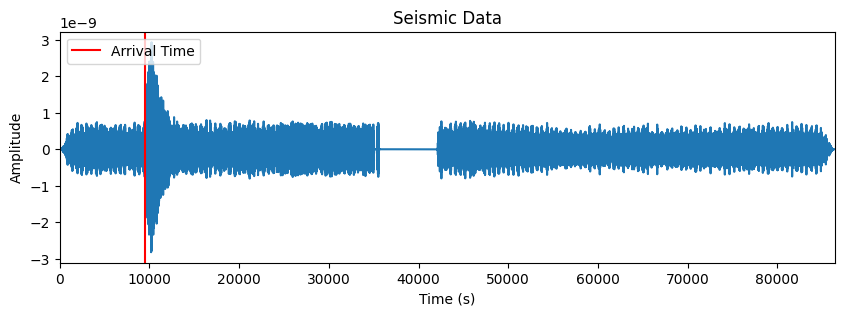

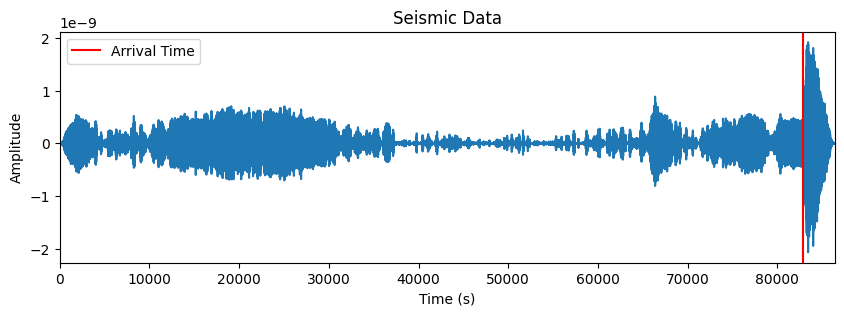

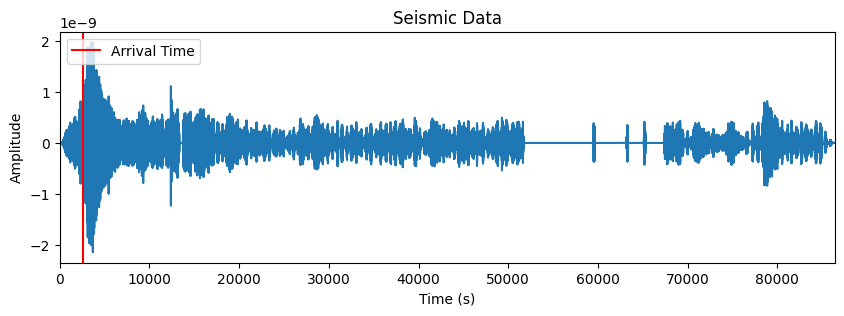

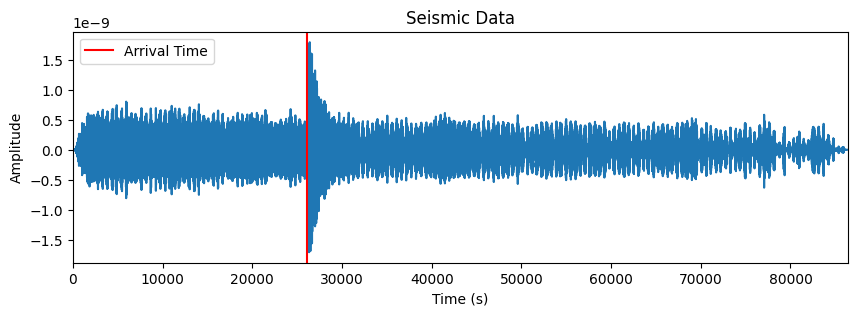

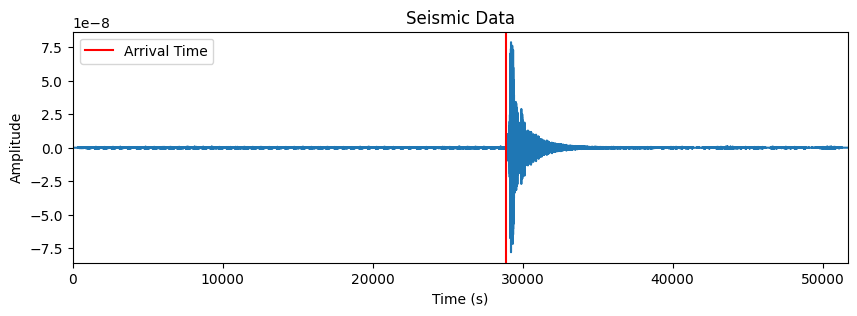

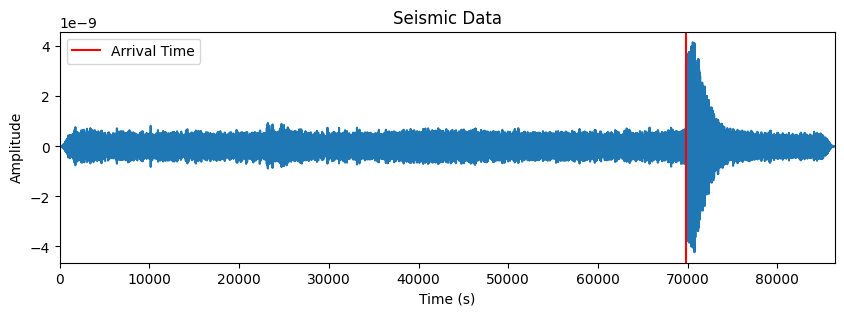

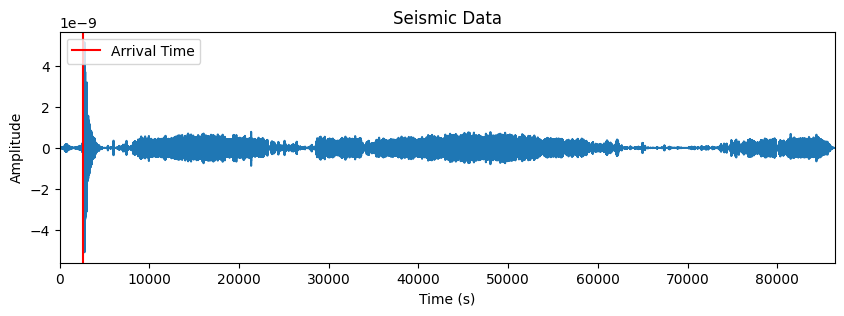

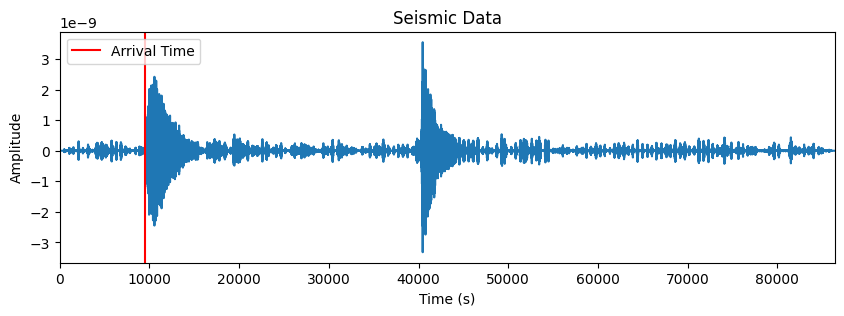

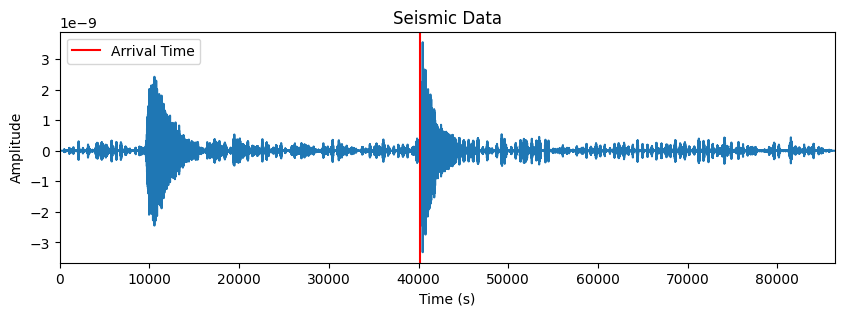

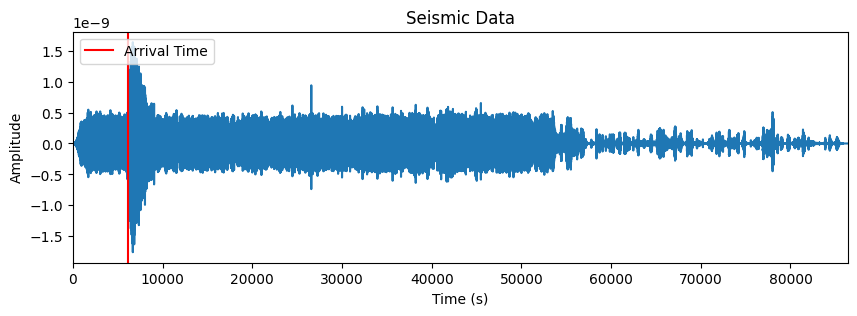

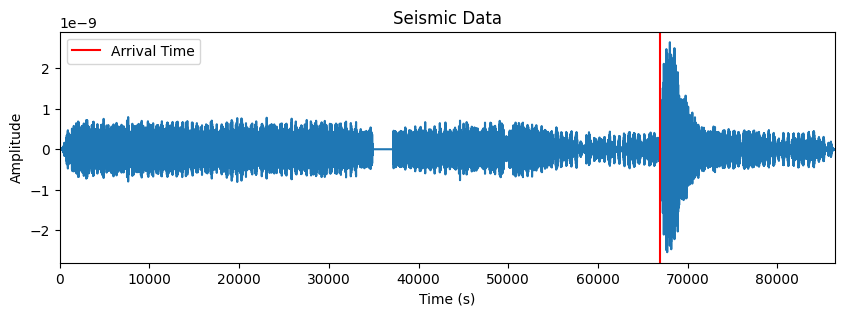

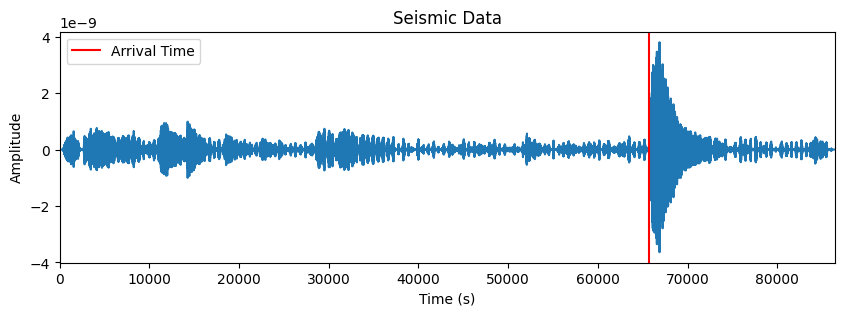

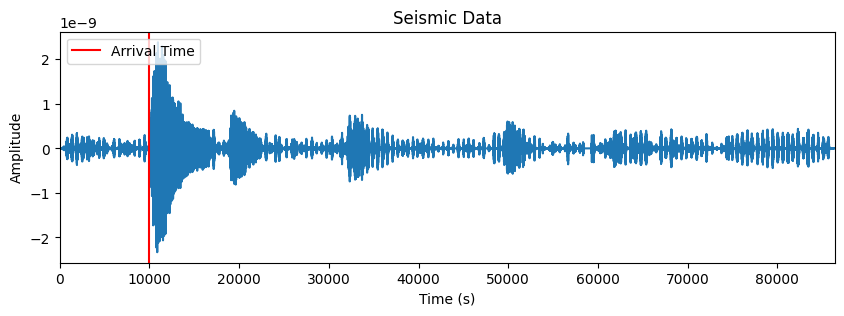

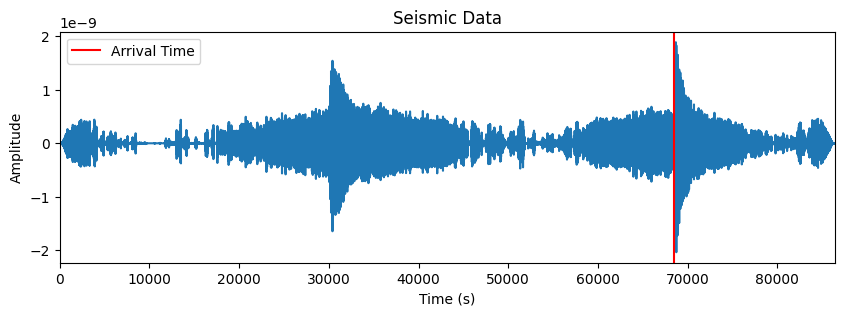

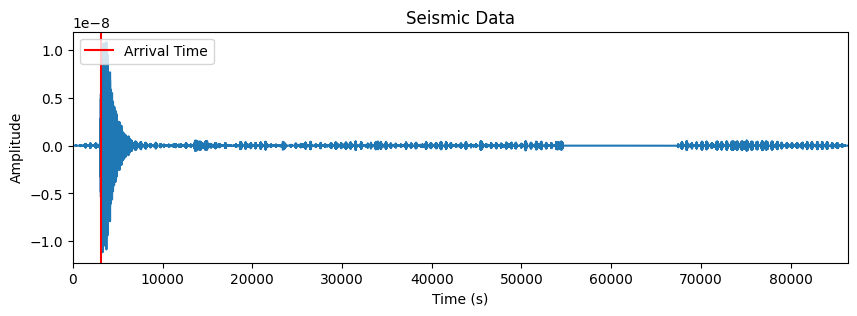

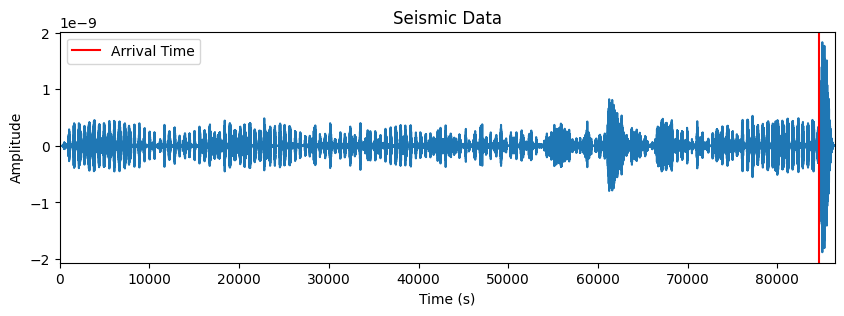

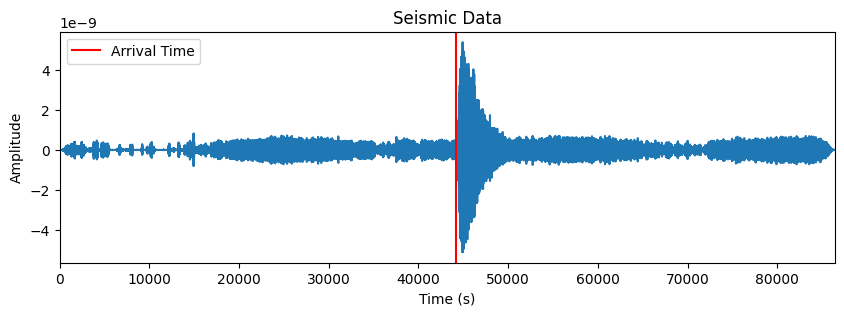

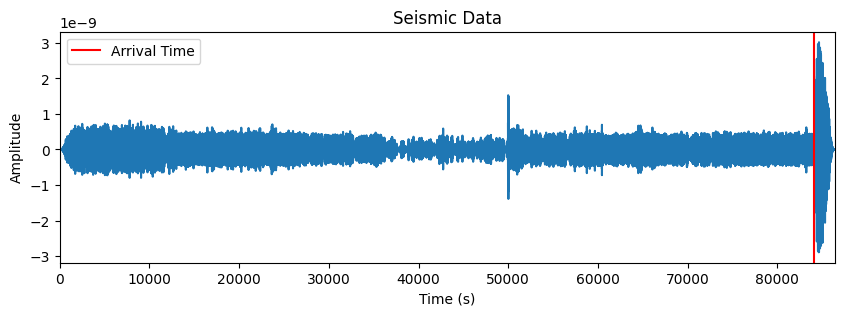

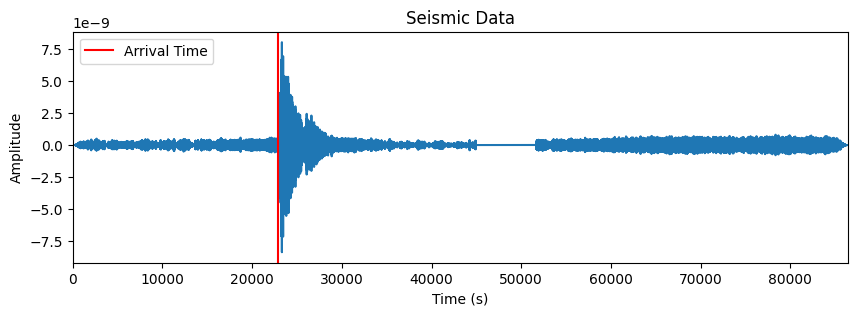

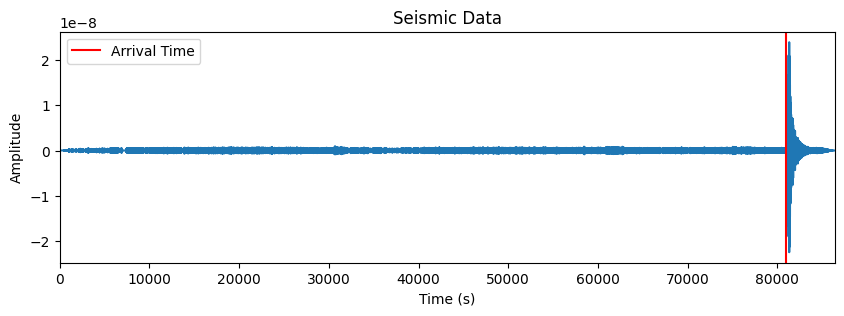

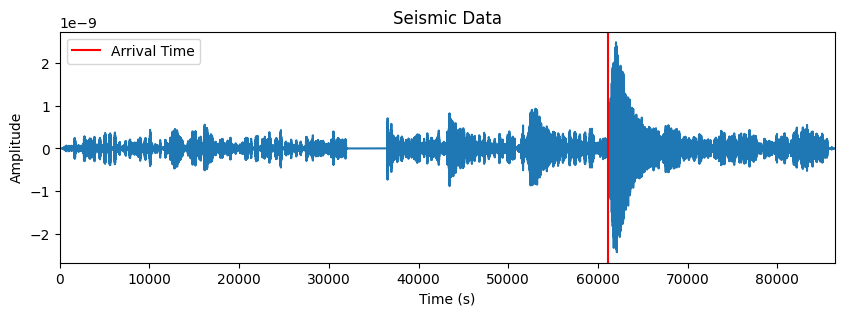

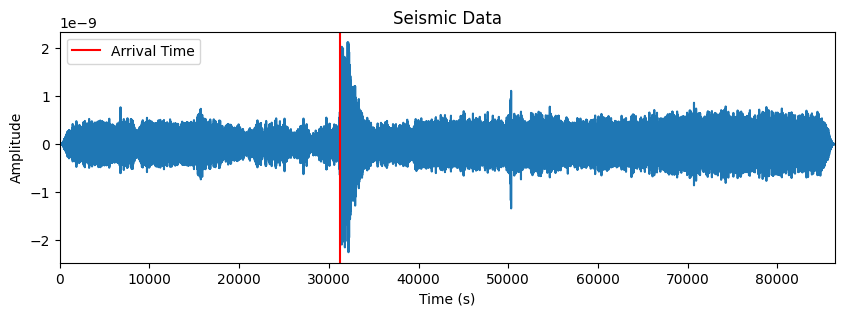

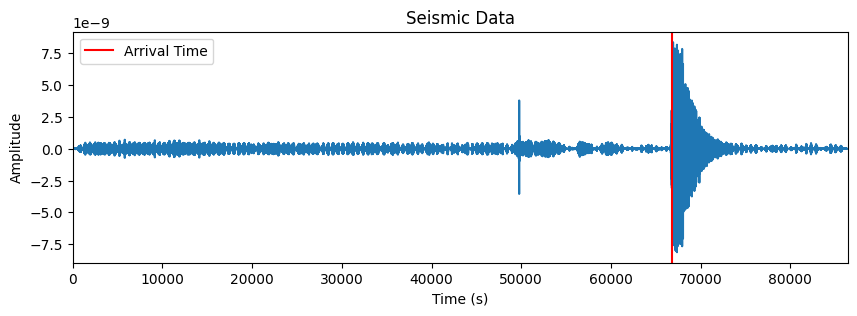

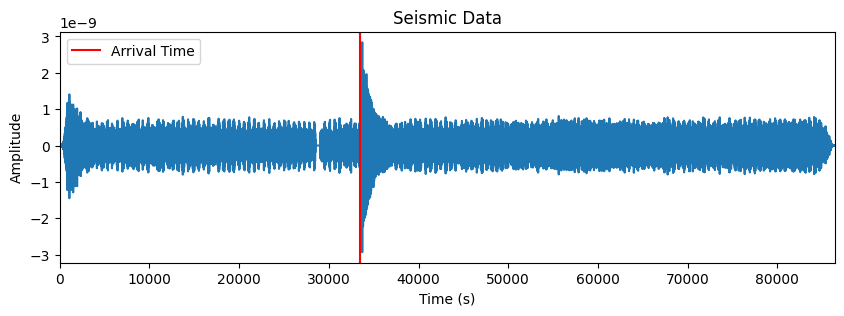

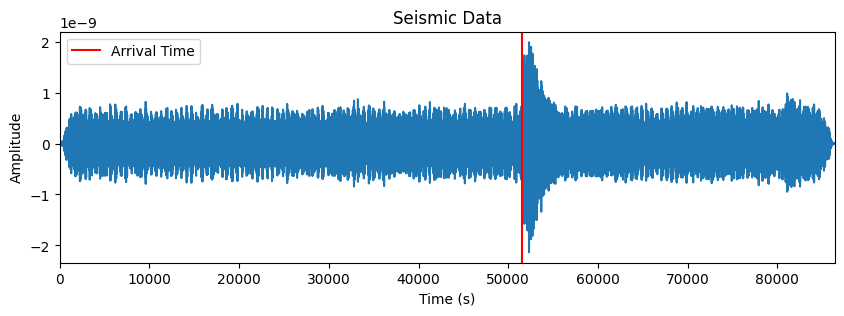

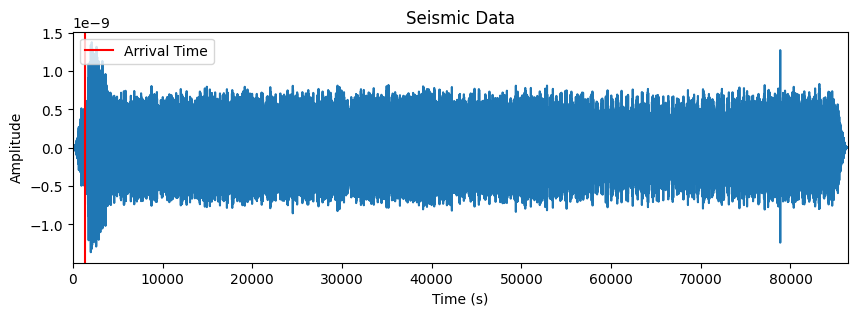

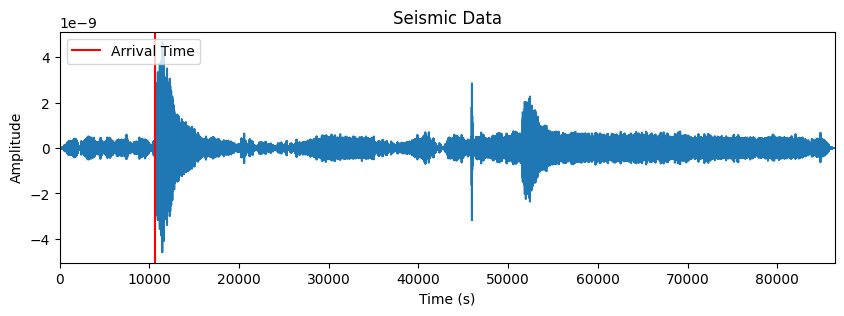

File not found: /content/drive/MyDrive/LunarGradeAData/xa.s12.00.mhz.1974-07-06HR00_evid00151.mseed. Skipping to the next file.
File not found: /content/drive/MyDrive/LunarGradeAData/xa.s12.00.mhz.1974-07-11HR00_evid00152.mseed. Skipping to the next file.
File not found: /content/drive/MyDrive/LunarGradeAData/xa.s12.00.mhz.1974-07-17HR00_evid00153.mseed. Skipping to the next file.
File not found: /content/drive/MyDrive/LunarGradeAData/xa.s12.00.mhz.1974-10-14HR00_evid00156.mseed. Skipping to the next file.
File not found: /content/drive/MyDrive/LunarGradeAData/xa.s12.00.mhz.1975-04-12HR00_evid00191.mseed. Skipping to the next file.
File not found: /content/drive/MyDrive/LunarGradeAData/xa.s12.00.mhz.1975-05-04HR00_evid00192.mseed. Skipping to the next file.
File not found: /content/drive/MyDrive/LunarGradeAData/xa.s12.00.mhz.1975-06-24HR00_evid00196.mseed. Skipping to the next file.
File not found: /content/drive/MyDrive/LunarGradeAData/xa.s12.00.mhz.1975-06-26HR00_evid00198.mseed. Ski

In [40]:
for i in range(0, cat.shape[0]):
    row = cat.iloc[i]
    try:

        time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
        rel_time = row['time_rel(sec)']
        filename = row['filename']


        data_directory = '/content/drive/MyDrive/LunarGradeAData'
        mseed_file = f'{data_directory}/{filename}.mseed'

        if load_mseed(mseed_file):
            tr = load_mseed(mseed_file)

            # Process the trace by getting the arrival and applying filters
            arrival = get_arrival(tr, time)
            tr_filt = apply_bandpass_filter(tr, 0.5, 1.0)

            # Plot the filtered traces (commented out for now)
            #plot_trace(tr_filt, arrival)

            #if needed
            tr_times_filt = tr_filt.times()
            tr_data_filt = tr_filt.data



            #EXTRACTING FEATURES





















    except FileNotFoundError:
        print(f"File not found: {mseed_file}. Skipping to the next file.")
    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")



